In [1]:
# -*- coding: utf-8 -*-
"""Brain Hemorrhage.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1UT39o8tOCSaRdZWcy5M6K0jxkyRVMro9
"""

'Brain Hemorrhage.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1UT39o8tOCSaRdZWcy5M6K0jxkyRVMro9\n'

In [2]:
# Commented out IPython magic to ensure Python compatibility.
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from skimage.io import imread, imshow
from skimage.transform import resize


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
# %matplotlib inline

In [3]:
IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 30

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [5]:
# Set environment variables for using the Kaggle API.
os.environ["KAGGLE_USERNAME"] = 'eyasuaregasema'
os.environ["KAGGLE_KEY"] = '1ca6b0d0c3fdaaed6b5d4b9bcbc63ce6'

In [6]:
raw_data_dir = "input/raw"

In [7]:
!kaggle datasets download -d eyasuaregasema/intracranial-hemorrhagedata -p {raw_data_dir}

 90% 81.0M/90.2M [00:02<00:00, 35.1MB/s]
100% 90.2M/90.2M [00:02<00:00, 36.5MB/s]


In [8]:
!ls {raw_data_dir}

intracranial-hemorrhagedata.zip


In [9]:
%%capture
!apt-get install -y fuse-zip

In [10]:
%%time

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/intracranial-hemorrhagedata.zip {input_dir}

CPU times: user 12 ms, sys: 16.6 ms, total: 28.5 ms
Wall time: 231 ms


In [11]:
!ls

gdrive	input  sample_data


In [12]:
# Check that everything is working.
!ls {input_dir}

computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0


In [13]:
path = '/tmp/kaggle-data/'
os.listdir(path)

['computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0']

In [14]:
# This is how to access the downloaded folders

base_path = '/tmp/kaggle-data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/'

os.listdir(base_path)

['LICENSE.txt',
 'Patients_CT',
 'README.txt',
 'SHA256SUMS.txt',
 'ct_ich.yml',
 'hemorrhage_diagnosis.csv',
 'patient_demographics.csv',
 'split_data.py']

In [15]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix

In [16]:
%%capture

! pip install segmentation-models

In [17]:
path = base_path + 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(path)

In [18]:
# The existing No_Hemorrhage target column is not intuitive. 
# Create a new target column to make the binary targets easier to understand.

def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

In [19]:
# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

In [20]:
# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

In [21]:
print(df_diag.shape)

(2501, 9)


In [22]:
df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage
0,49,1,0,0,0,0,0,0,0
1,49,2,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,0,0
3,49,4,0,0,0,0,0,0,0
4,49,5,0,0,0,0,0,0,0


In [23]:
# Patient 84
# Brain image 36.jpg exists but bone image 36.jpg is missing.

# Therefore, we will drop this row from the dataframe.

index_to_drop = df_diag[(df_diag['PatientNumber'] == 84) & (df_diag['SliceNumber'] == 36)].index

index_to_drop = index_to_drop[0]

df_diag = df_diag.drop(index_to_drop, axis=0)


# Check that the row that we dropped has been removed
df_diag[df_diag.index == index_to_drop]

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage


In [24]:
# Create new columns


def get_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    


# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)


def new_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)


def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname

# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    


# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)


df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,1,0,0,0,0,0,0,0,1_HGE_Seg.jpg,49_1_HGE_Seg.jpg,1.jpg,49_1.jpg
1,49,2,0,0,0,0,0,0,0,2_HGE_Seg.jpg,49_2_HGE_Seg.jpg,2.jpg,49_2.jpg
2,49,3,0,0,0,0,0,0,0,3_HGE_Seg.jpg,49_3_HGE_Seg.jpg,3.jpg,49_3.jpg
3,49,4,0,0,0,0,0,0,0,4_HGE_Seg.jpg,49_4_HGE_Seg.jpg,4.jpg,49_4.jpg
4,49,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,49_5_HGE_Seg.jpg,5.jpg,49_5.jpg


In [25]:
path = base_path + 'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [26]:
# create a new mask dir
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

In [27]:
# For non blank masks

for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 1]
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # Source path to mask.
        # All masks are in the brain folder.
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(mask_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
 
# Check how many masks are in the new folder. (Should be 318)
len(os.listdir('mask_dir'))

318

In [28]:
# For blank masks

blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 0]  # <-- for empty masks change filter here
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # set the destination where the file will be saved
        dst = os.path.join(mask_dir, new_fname)
      
        # save the image
        cv2.imwrite(dst, blank_mask)
        
 
# Check how many masks are in the new folder. (Should be 2500)
len(os.listdir('mask_dir'))



2500

In [29]:
# create a new mask dir
brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

In [30]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(brain_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        

# Check how many images are in the new folder (Should be 2500)
len(os.listdir('brain_image_dir'))

2500

In [31]:
# create a new mask dir
bone_image_dir = 'bone_image_dir'
os.mkdir(bone_image_dir)

In [32]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_path + 'Patients_CT/' + folder_name + '/bone'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(bone_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        
# Check how many images are in the new folder (Should be 2500)
len(os.listdir('bone_image_dir'))

2500

(650, 650)


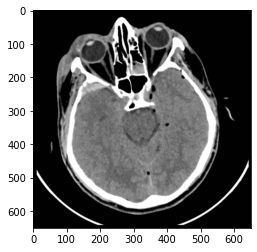

In [33]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = plt.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


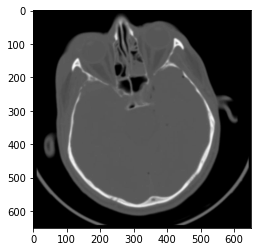

In [34]:
# bone image

fname = df_diag.loc[index, 'new_image_fname']
path = 'bone_image_dir/' + fname
# read the image as a matrix
bone_image = plt.imread(path)

print(bone_image.shape)

plt.imshow(bone_image, cmap='gray')

(650, 650)


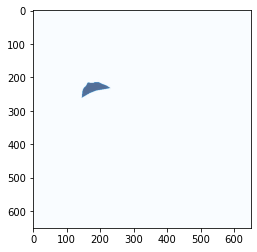

In [35]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

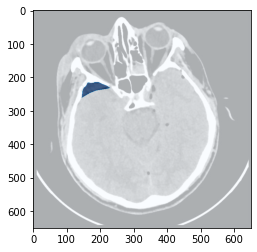

In [36]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

In [37]:
# HOW TO DO MULTIPLE AUGMENTATIONS

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


# This how to call the function
# aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)

(650, 650, 3)


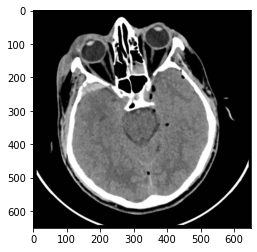

In [38]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# read the image as a matrix
brain_image = cv2.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


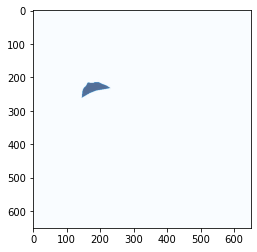

In [39]:
# mask

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
# read the image as a matrix
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

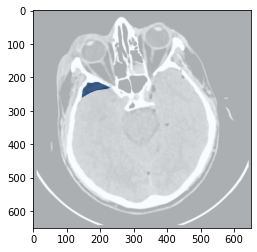

In [40]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

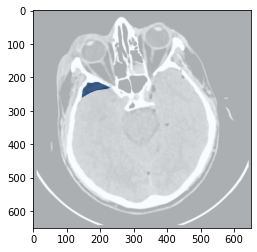

In [41]:
# Example augmentation - image and mask

# augment the image and mask
aug_image, aug_mask = augment_image_and_mask(aug_types, brain_image, mask)



plt.imshow(aug_image, cmap='gray')
plt.imshow(aug_mask, cmap='Blues', alpha=0.7)

In [42]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_image_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
   
  
  
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

In [43]:
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()

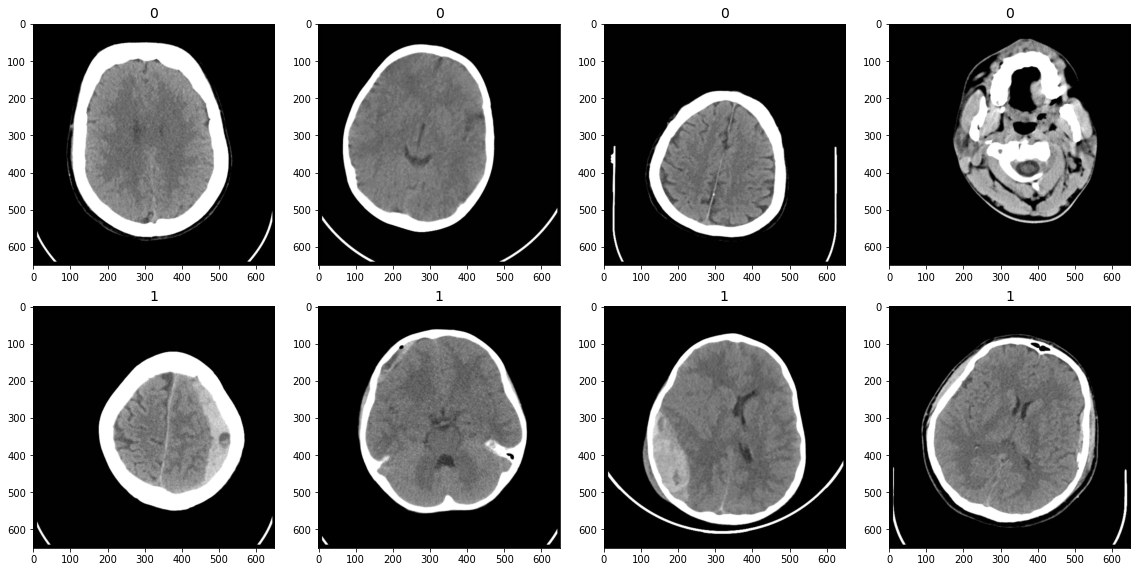

In [44]:
# Brain images

IMAGE_PATH = 'brain_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

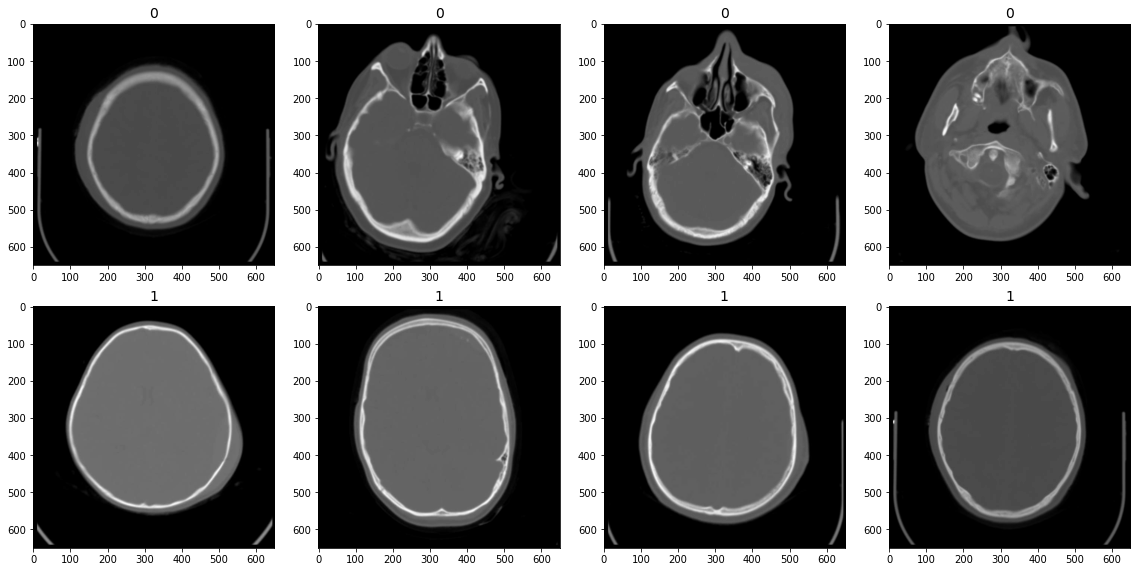

In [45]:
# Bone images

IMAGE_PATH = 'bone_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

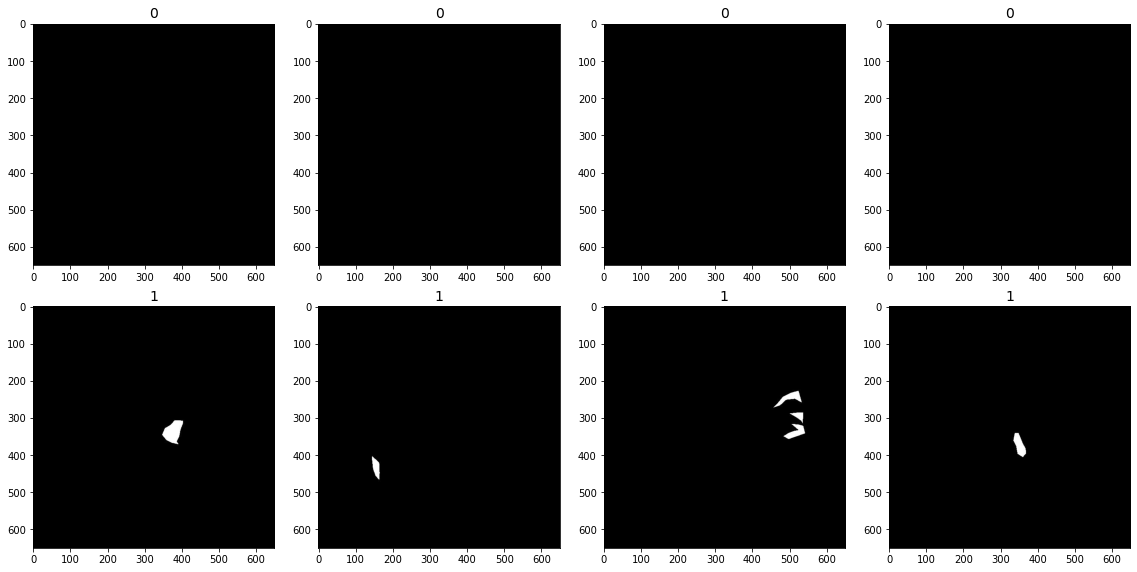

In [46]:
# Masks

IMAGE_PATH = 'mask_dir/'

draw_category_masks('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

In [47]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2480, 13)
(20, 13)


In [48]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(372, 13)


In [49]:
df_train['Has_Hemorrhage'].value_counts()

0    1846
1     262
Name: Has_Hemorrhage, dtype: int64

In [50]:
df_val['Has_Hemorrhage'].value_counts()

0    326
1     46
Name: Has_Hemorrhage, dtype: int64

In [51]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)


In [52]:
# check if the files were saved
!ls

bone_image_dir	 df_data.csv.gz  df_train.csv.gz  gdrive  mask_dir
brain_image_dir  df_test.csv.gz  df_val.csv.gz	  input   sample_data


In [53]:
from segmentation_models import  get_preprocessing # this line has an error in the docs

BACKBONE = 'densenet201'
preprocess_input = get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [54]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
              
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                # insert the image into Y_train
                Y_train[i] = aug_mask
                
                
                
                
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, Y_train

In [55]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)

# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


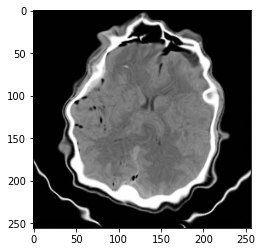

In [56]:
# print the first image in X_train

img = X_train[7,:,:,:]
plt.imshow(img)

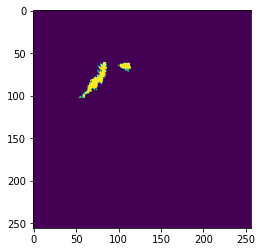

In [57]:
# print the mask in Y_train

msk = Y_train[7,:,:,0]
plt.imshow(msk)

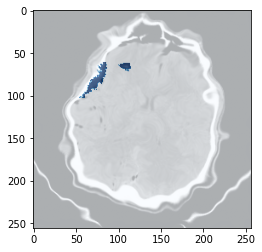

In [58]:
plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

In [59]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                
            
            # Normalize the images
            X_val = X_val/255
            
            yield X_val, Y_val

In [60]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


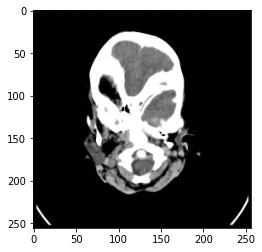

In [61]:
# print the image from X_val

img = X_val[7,:,:,:]
plt.imshow(img)

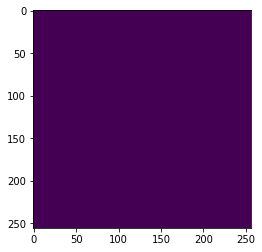

In [62]:
# print the mask from Y_val

msk = Y_val[7,:,:,0]
plt.imshow(msk)

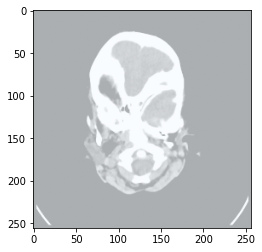

In [63]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

In [64]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test


In [65]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


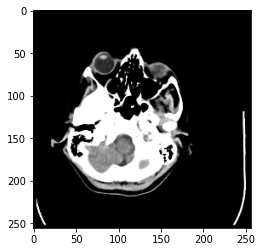

In [66]:
# print the image from X_test

img = X_test[14,:,:,:]
plt.imshow(img)

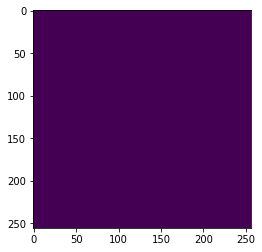

In [67]:
# print the mask from Y_test

msk = Y_test[14,:,:,0]
plt.imshow(msk)

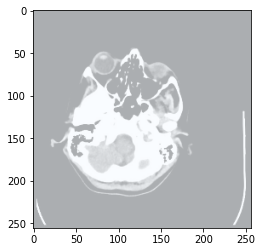

In [68]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

In [69]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import tensorflow as tf

print(tf.__version__)

2.8.2


In [71]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

import tensorflow as tf

In [72]:
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

In [73]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [74]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

BACKBONE = 'densenet201'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()

74850304/74836368 [==============================] - 5s 0us/step


In [75]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


(20, 256, 256, 3)
(20, 256, 256, 1)


In [76]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [77]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

model.compile(
    Adam(lr=0.001),
    loss=binary_crossentropy,
    metrics=['accuracy'],
)


filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9900

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()



Epoch 1: val_loss improved from inf to 0.11769, saving model to model.h5
71/71 [==============================] - 141s 1s/step - loss: 0.1177 - accuracy: 0.9900 - val_loss: 0.1177 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9987
Epoch 2: val_loss improved from 0.11769 to 0.02847, saving model to model.h5
71/71 [==============================] - 70s 991ms/step - loss: 0.0181 - accuracy: 0.9987 - val_loss: 0.0285 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9986
Epoch 3: val_loss improved from 0.02847 to 0.01341, saving model to model.h5
71/71 [==============================] - 71s 1s/step - loss: 0.0119 - accuracy: 0.9986 - val_loss: 0.0134 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9987
Epoch 4: val_loss improved from 0.01341 to 0.01048, saving mode

In [78]:
# save the model to google drive

Exp = 'Exp_13'

path_model = '/content/drive/MyDrive/Colab/Kaggle/Intracranial_Hemorrhage_Analyzer/Segmentation_Experiments/Exp_13/model.h5'

model.load_weights('model.h5')

model.save(path_model)  

In [79]:
#initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


20/20 [==============================] - 6s 36ms/step


In [80]:
!ls

bone_image_dir	 df_test.csv.gz   drive   mask_dir     training_log.csv
brain_image_dir  df_train.csv.gz  gdrive  model.h5
df_data.csv.gz	 df_val.csv.gz	  input   sample_data


In [81]:
preds_test_thresh = (predictions >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
0


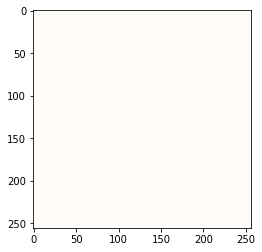

In [82]:
# This is a predicted mask

mask = preds_test_thresh[3,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

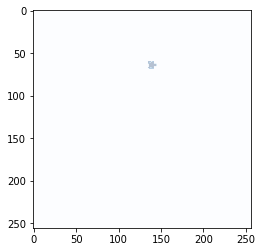

In [83]:
# This is a true mask

true_mask = Y_test[3,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

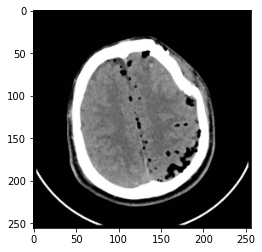

In [84]:
# This is the x-ray image

image = X_test[3,:,:,:]

plt.imshow(image)

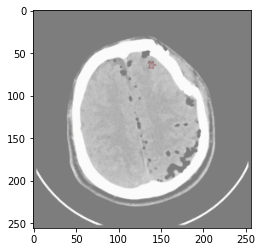

In [85]:
# This is an overlay of the pred mask, true mask and 
# the x-ray image.

plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)

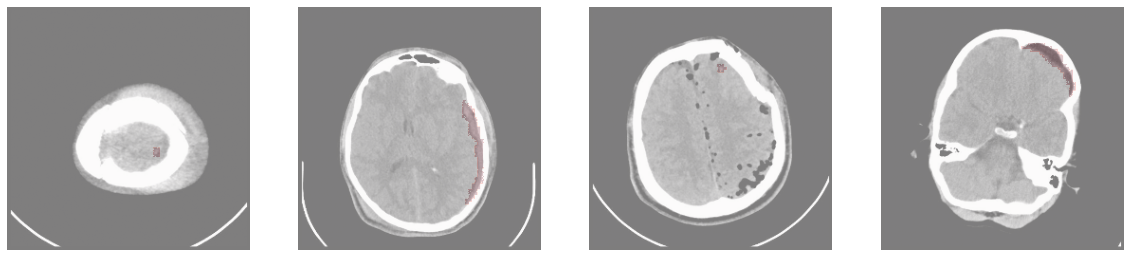

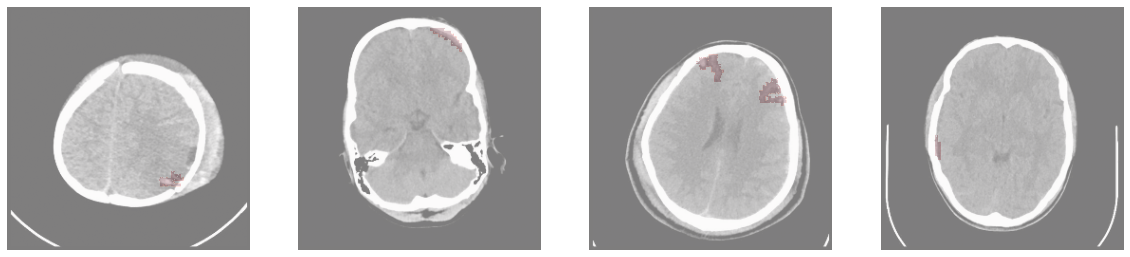

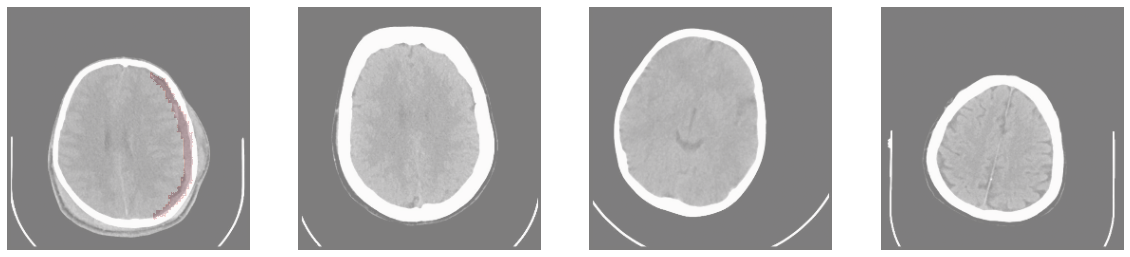

In [86]:
# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')

predicted_masks = preds_test_thresh



    
# image
plt.subplot(1,4,1)
image = X_test[1,:,:,:] 
mask = predicted_masks[1, :, :, 0]
true_mask = Y_test[1, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[2,:,:,:] 
mask = predicted_masks[2, :, :, 0]
true_mask = Y_test[2, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[3,:,:,:]
mask = predicted_masks[3, :, :, 0]
true_mask = Y_test[3, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[4,:,:,:] 
mask = predicted_masks[4, :, :, 0]
true_mask = Y_test[4, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')



# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[5,:,:,:] 
mask = predicted_masks[5, :, :, 0]
true_mask = Y_test[5, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[6,:,:,:] 
mask = predicted_masks[6, :, :, 0]
true_mask = Y_test[6, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[7,:,:,:] 
mask = predicted_masks[7, :, :, 0]
true_mask = Y_test[7, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[8,:,:,:] 
mask = predicted_masks[8, :, :, 0]
true_mask = Y_test[8, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[9,:,:,:] 
mask = predicted_masks[9, :, :, 0]
true_mask = Y_test[9, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[10,:,:,:] 
mask = predicted_masks[10, :, :, 0]
true_mask = Y_test[10, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[11,:,:,:] 
mask = predicted_masks[11, :, :, 0]
true_mask = Y_test[11, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[12,:,:,:] 
mask = predicted_masks[12, :, :, 0]
true_mask = Y_test[12, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


plt.show()

In [87]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 40 kB 5.3 MB/s 
     |████████████████████████████████| 108 kB 72.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 98 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 50.7 MB/s 
     |████████████████████████████████| 15.7 MB 48.6 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 4.5 MB 47.1 MB/s 
     |████████████████████████████████| 1.6 MB 54.8 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 5.8 MB 43.4 MB/s 
     |████████████████████████████████| 438 kB 65.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 57 kB 5.4 MB/s 
     |████████████████████████████████| 1

In [88]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [89]:
# check that the folder containing the tfjs model files has been created
!ls

bone_image_dir	 df_test.csv.gz   drive   mask_dir     tfjs
brain_image_dir  df_train.csv.gz  gdrive  model.h5     training_log.csv
df_data.csv.gz	 df_val.csv.gz	  input   sample_data


In [96]:
# Dowload the converted tfjs model folder - to my computer

# create a zip file
!zip -r /content/file.zip /content/tfjs

# download that zip file
from google.colab import files
files.download("/content/file.zip") # note: the name file.zip is correct

updating: content/tfjs/ (stored 0%)
updating: content/tfjs/model/ (stored 0%)
updating: content/tfjs/model/group1-shard20of26.bin (deflated 8%)
updating: content/tfjs/model/group1-shard1of26.bin (deflated 6%)
updating: content/tfjs/model/group1-shard19of26.bin (deflated 8%)
updating: content/tfjs/model/group1-shard21of26.bin (deflated 8%)
updating: content/tfjs/model/group1-shard16of26.bin (deflated 7%)
updating: content/tfjs/model/group1-shard9of26.bin (deflated 6%)
updating: content/tfjs/model/group1-shard18of26.bin (deflated 8%)
updating: content/tfjs/model/group1-shard23of26.bin (deflated 8%)
updating: content/tfjs/model/group1-shard3of26.bin (deflated 6%)
updating: content/tfjs/model/group1-shard14of26.bin (deflated 6%)
updating: content/tfjs/model/model.json (deflated 96%)
updating: content/tfjs/model/group1-shard26of26.bin (deflated 7%)
updating: content/tfjs/model/group1-shard11of26.bin (deflated 6%)
updating: content/tfjs/model/group1-shard6of26.bin (deflated 6%)
updating: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
import os

In [100]:
path = '/content/drive/MyDrive/Colab/Kaggle/Intracranial_Hemorrhage_Analyzer/Segmentation_Experiments/Exp_13/model.h5'

# source path to image
src = os.path.join('train', fname)
# destination path to image
dst = os.path.join(train_dir, label, fname)
# copy the image from the source to the destination
shutil.copytree('tfjs', path)

NameError: ignored

In [ ]:
# Delete the image data directorys we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('brain_image_dir') == True: # return true if the directory exists
    
    #shutil.rmtree('brain_image_dir')
    

if os.path.isdir('bone_image_dir') == True: # return true if the directory exists
    
    #shutil.rmtree('bone_image_dir')
    

if os.path.isdir('mask_dir') == True: # return true if the directory exists
    
    #shutil.rmtree('mask_dir')